# Prediction market calibration

This is a probability and statistics course project analyzing prediction market data.

## Introduction

### Calibration and Accuracy

We can measure how good prediction markets are at forecasting events by looking at their calibration and accuracy.

**Calibration** measures how well the predicted probabilities correspond to actual outcomes. For example, if we look at all events where the market predicted a 70% chance of the event happening, and after those events have resolved, we find that the event actually happened in 70% of those cases, then the market is well-calibrated (at that probability level).

**Accuracy** measures how close the predicted probabilities are to the actual outcomes. We can measure this using the Brier score, which is a proper scoring rule for probabilistic forecasts.

### Brier score

Brier score is defined as $\text{BS} = \frac{1}{N} \sum_{i=1}^{N} (f_i - o_i)^2$, where $f_i$ is the forecast probability, $o_i$ is the outcome (0 or 1), and N is the number of forecasts. Lower Brier score is better, with 0 being perfect and 1 being the worst.

### Brier skill score

How good are the brier scores? We can use a Brier Skill Score (BSS) to measure this.
The BSS is defined as $\text{BSS} = 1 - \frac{\text{BS}}{\text{BS}_{\text{ref}}}$, where $\text{BS}$ is the Brier score of the forecast, and $\text{BS}_{\text{ref}}$ is the Brier score of a reference forecast. Higher BSS is better, with 1 being perfect and 0 tied with the reference forecast.

We can use 2 different reference forecasts:
1. Coin flip - always predict 0.5. This is not a very strong baseline as it can be beaten easily in rare or very common events.
2. Base rate - always predict the base rate of the event. This is a stronger baseline.

The coin flip will always have a Brier score of $0.25$, so the BSS can be computed as $\text{BSS}_\text{coin} = 1 - \frac{\text{BS}}{0.25} = 1 - 4 \cdot \text{BS}$.

We can compute the base rate Brier score as $\text{BS}_{\text{base}} = \bar{o}(\bar{o}-1)^2 + (1-\bar{o})(\bar{o}-0)^2 = \bar{o}(1 - \bar{o})$, where $\bar{o}$ is the base rate (fraction of positive outcomes). The BSS can then be computed as $\text{BSS}_\text{base} = 1 - \frac{\text{BS}}{\bar{o}(1 - \bar{o})}$. We need to obtain the base rate $\bar{o}$ from the data.

## Data

The data used is from [brier.fyi](https://brier.fyi/), a site aggregating prediction market data from various platforms and providing a homogeneous API. It also provides calibration scores for each market and groups markets into questions.
The data itself is provided by a postgREST endpoint at [data.brier.fyu](https://data.brier.fyi), the OpenAPI spec is [attached](openapi.json).

I picked a single point for both the market brier score and predicted probability - 7 days before resolution. This is to allow a simple comparison across markets. 7 days before close seems the most sensible alternative - it is not yet contaminated by resolution information, but should be representative of the "final" predication. It is also more stable stand e.g. the midpoint and not affected by very early/late probability swings as with the average. Other points may be suitable for analysis too (and could produce different results).

The data is stored in [data/markets_brier7d.csv](data/markets_brier7d.csv).
To re-fetch most recent data, run `python fetch_data.py`.

Refetching the newest data might take a while, avoid running this repeatedly to not overload the API.
This is not necessary and might even be undesirable for reproducibility - the data is attached. Only run if you want the most recent data.

## Setup

This notebook will use pandas, numpy, matplotlib and seaborn for data analysis and visualization.

Install with `pip install -r requirements.txt`.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, matplotlib as mpl
from scipy import stats

DATA_PATH = "data/markets_brier7d.csv"

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.05)
mpl.rcParams.update({
    "figure.dpi": 140,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

We load the raw data obtained above from the CSV file.

In [2]:
df = pd.read_csv(DATA_PATH, dtype={'question_invert':'boolean'}, true_values=['t'], false_values=['f'])
df.rename(columns={"score_brier7d": "score", "probability_7d": "probability"}, inplace=True)
print(f"Loaded {len(df)} rows from {DATA_PATH}")

Loaded 128612 rows from data/markets_brier7d.csv


## Cleaning

We do some basic cleaning of the data - remove duplicates, rows with missing key values and markets shorter than 7 days, as the score used is 7d before close.

In [3]:
before_clean = len(df)
df = df \
    .drop_duplicates('market_id') \
    .dropna(subset=['score', 'close_datetime', 'volume_usd', 'traders_count']) \
    .query('duration_days >= 7')

print(f"Dropped {before_clean - len(df)} rows during cleaning, {len(df)} rows remain.")

Dropped 20906 rows during cleaning, 107706 rows remain.


## Constants

We use these constants to determine e.g. what is a "high volume" market.

In [4]:
MIN_VOLUME = 5000  # USD
MIN_TRADERS = 20  # traders
MIN_DURATION = 30  # days

LOG_LABELS = ['1', '10', '100', '1k', '10k', '100k', '1M', '10M', '100M', '1B']
USD_LOG_LABELS = [f"${l}" for l in LOG_LABELS]

def filter_high_volume(d):
    return d.query('volume_usd >= @MIN_VOLUME').query('duration_days >= @MIN_DURATION').query(
        'traders_count >= @MIN_TRADERS')

## Preprocessing

In [5]:
df['log_volume_usd'] = np.log10(df['volume_usd'] + 1)
df['log_traders_count'] = np.log10(df['traders_count'] + 1)
df['skill_score_coin'] = 1 - df['score'] / 0.25
base_rate = df['resolution'].mean()
df['skill_score_base'] = 1 - df['score'] / (base_rate * (1 - base_rate))

## Overall accuracy

Let's take a look at the overall accuracy score of the markets in the dataset.

In [6]:
print("Overall Brier score statistics:")
print(f"Overall median Brier score: {df['score'].median():.4f}")
df['score'].describe()

Overall Brier score statistics:
Overall median Brier score: 0.0293


count    107706.000000
mean          0.131473
std           0.201001
min           0.000000
25%           0.002557
50%           0.029321
75%           0.189145
max           1.000000
Name: score, dtype: float64

We can also compute the 95% confidence interval for the mean Brier score:

In [7]:
z = stats.norm.ppf(1 - 0.05/2)
se = df['score'].std() / np.sqrt(len(df))
mean = df['score'].mean()
print(f"Overall mean Brier score: {mean:.4f} ± {z * se:.4f} (95%-CI)")

Overall mean Brier score: 0.1315 ± 0.0012 (95%-CI)


What about the Brier skill scores?

In [8]:
print(f"Overall base rate: {base_rate:.4f} ({df['resolution'].sum():.0f} positive resolutions out of {len(df)})")
mean_skill_score_coin = df['skill_score_coin'].mean()
mean_skill_score_base = df['skill_score_base'].mean()
print(f"Overall mean Brier skill score (coin flip): {mean_skill_score_coin:.4f}")
print(f"Overall mean Brier skill score (base rate): {mean_skill_score_base:.4f}")
print(
    f"That means the markets have overall {abs(mean_skill_score_coin) * 100:.1f}% {(mean_skill_score_coin > 0) and 'lower' or 'higher'} brier score than a coin flip, and {abs(mean_skill_score_base) * 100:.1f}% {(mean_skill_score_base > 0) and 'lower' or 'higher'} score than the base rate. (Lower brier score is better, higher skill score is better)")

Overall base rate: 0.3990 (42976 positive resolutions out of 107706)
Overall mean Brier skill score (coin flip): 0.4741
Overall mean Brier skill score (base rate): 0.4517
That means the markets have overall 47.4% lower brier score than a coin flip, and 45.2% lower score than the base rate. (Lower brier score is better, higher skill score is better)


Looking at the higher volume markets only:

In [9]:
df_big = filter_high_volume(df)
base_rate_big = df_big['resolution'].mean()
df_big['skill_score_base_big'] = 1 - df_big['score'] / (base_rate_big * (1 - base_rate_big))
mean = df_big['score'].mean()
std = df_big['score'].std()

print(f"High volume mean Brier score: {mean:.4f}")
print(f"High volume median Brier score: {df_big['score'].median():.4f}")
print(f"High volume stddev of Brier score: {std:.4f}")

se = std / np.sqrt(len(df_big))
print(f"Overall mean Brier score: {mean:.4f} ± {z * se:.4f} (95%-CI)")
print()

print(
    f"High volume base rate: {base_rate_big:.4f} ({df_big['resolution'].sum():.0f} positive resolutions out of {len(df_big)})")
mean_skill_score_coin = df_big['skill_score_coin'].mean()
mean_skill_score_base = df_big['skill_score_base_big'].mean()
print(f"High volume mean Brier skill score (coin flip): {mean_skill_score_coin:.4f}")
print(f"High volume mean Brier skill score (base rate): {mean_skill_score_base:.4f}")
print(
    f"That means the high volume markets have {abs(mean_skill_score_coin) * 100:.1f}% {(mean_skill_score_coin > 0) and 'lower' or 'higher'} brier score than a coin flip, and {abs(mean_skill_score_base) * 100:.1f}% {(mean_skill_score_base > 0) and 'lower' or 'higher'} score than the base rate. (Lower brier score is better, higher skill score is better)")

High volume mean Brier score: 0.0660
High volume median Brier score: 0.0005
High volume stddev of Brier score: 0.1612
Overall mean Brier score: 0.0660 ± 0.0045 (95%-CI)

High volume base rate: 0.2532 (1237 positive resolutions out of 4886)
High volume mean Brier skill score (coin flip): 0.7361
High volume mean Brier skill score (base rate): 0.6511
That means the high volume markets have 73.6% lower brier score than a coin flip, and 65.1% lower score than the base rate. (Lower brier score is better, higher skill score is better)


Overall, the markets seem to be reasonably accurate, beating both a coin flip and the base rate by a good margin.

## Accuracy and volume

Next, we'll look at the relation between market accuracy and the volume in $USD traded. Intuition would suggest that accuracy should rise with volume, but is this actually true?

In the following sections, remember that with brier score, lower is better.

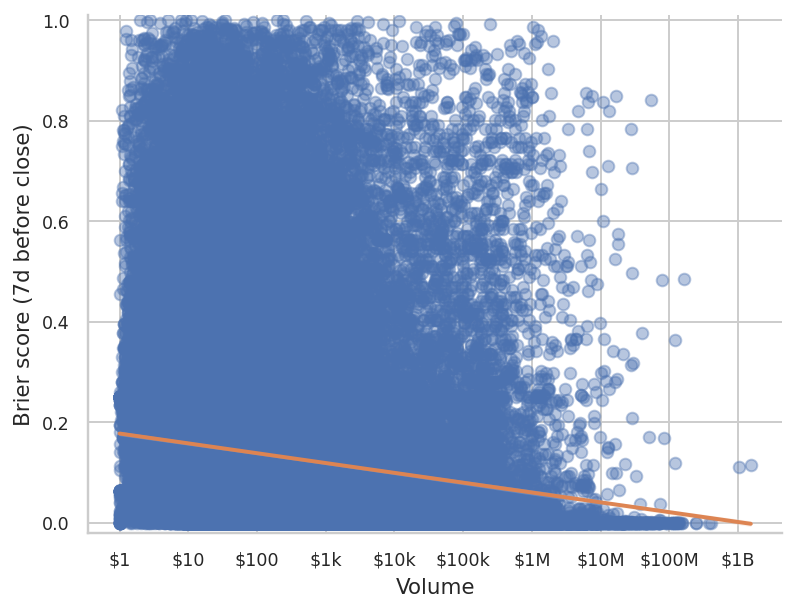

In [10]:
ax = sns.regplot(data=df, x='log_volume_usd', y='score', scatter_kws={'alpha': 0.4}, line_kws={'lw': 2, 'color': 'C1'})
ax.set(xlabel='Volume', ylabel='Brier score (7d before close)', ylim=(-.02, 1.01), xticks=range(10), xticklabels=USD_LOG_LABELS)
plt.show()

The plot above seems to indicate a small negative correlation (which really does mean rising accuracy), but is very noisy and the regression line is not very meaningful.
We will try something clearer.

The following bins the volumes into deciles and plots the median score per bin, with interquartile range (25th to 75th percentile) shaded.

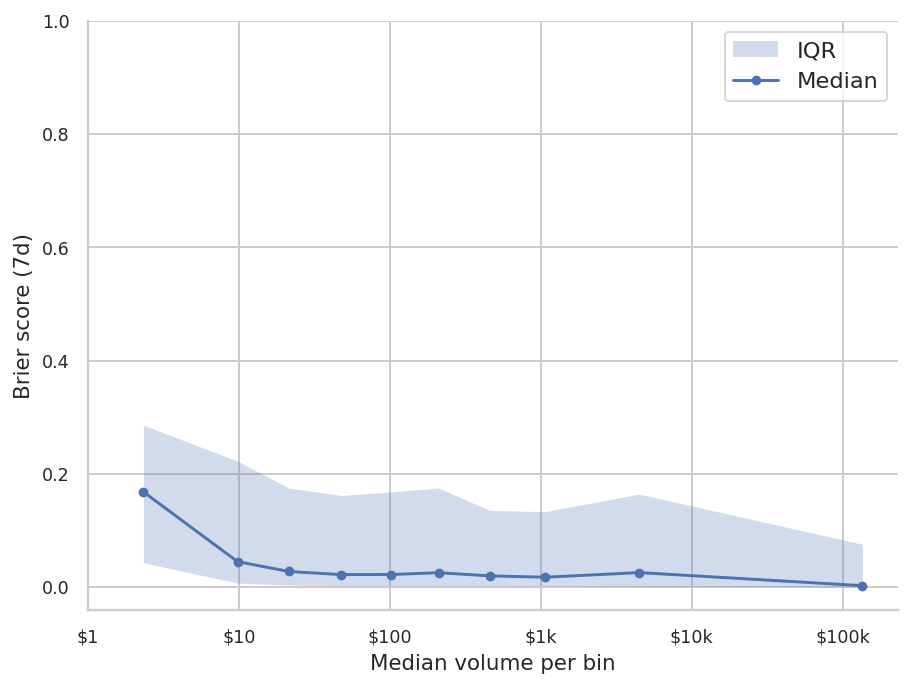

In [11]:
q = pd.qcut(df['volume_usd'], 10, duplicates='drop')
h = (df.assign(bin=q)
     .groupby('bin', observed=False)
     .agg(vol_mid=('volume_usd', 'median'),
          score_mid=('score', 'median'),
          score_q1=('score', lambda s: s.quantile(.25)),
          score_q3=('score', lambda s: s.quantile(.75)))
     .reindex())
fig, ax = plt.subplots(constrained_layout=True)
ax.fill_between(h['vol_mid'], h['score_q1'], h['score_q3'], alpha=0.25, linewidth=0, label='IQR')
ax.plot(h['vol_mid'], h['score_mid'], 'o-', lw=1.5, ms=4, label='Median')
ax.set(xscale='log', ylim=(-.04, 1), xlabel='Median volume per bin', ylabel='Brier score (7d)', xticks=10**np.arange(0, 6), xticklabels=USD_LOG_LABELS[0:6])
ax.legend();
plt.show()

This seems to support the negative correlation, plateauing at higher volumes. Accuracy thus seems to correlate with volume - even in the whole dataset, containing both very little volume (10\\$) and very high volume (100M\\$) markets.

### Higher volume markets

Let's take a look at a subset of the data with some sensible volume - at least $5k, longer duration (at least 30d), and least 100 traders. I also zoom in on the score axis in the second plot.

4886 rows with volume >= $5000, duration >= 30d and traders >= 20 remain.


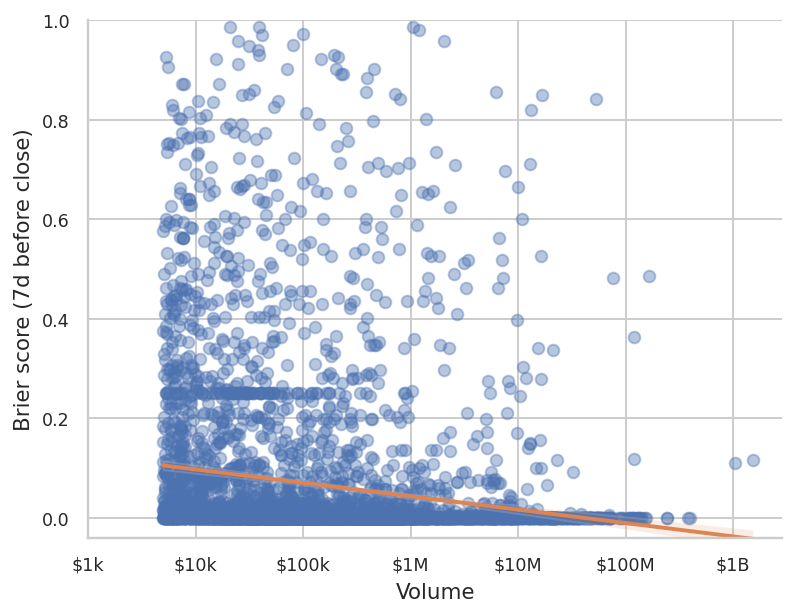

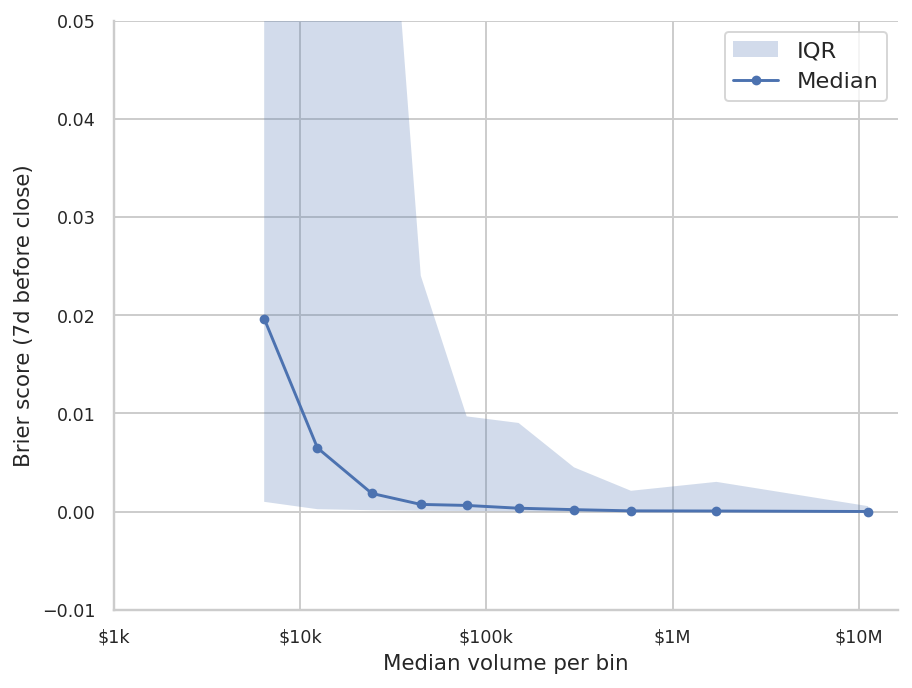

In [12]:
df_big = filter_high_volume(df)
print(
    f"{len(df_big)} rows with volume >= ${MIN_VOLUME}, duration >= {MIN_DURATION}d and traders >= {MIN_TRADERS} remain.")

ax = sns.regplot(data=df_big, x='log_volume_usd', y="score", scatter_kws={'alpha': 0.4},
                 line_kws={'lw': 2, 'color': 'C1'})
ax.set(xlabel='Volume', ylabel='Brier score (7d before close)', ylim=(-.04, 1), xticks=range(3,10), xticklabels=USD_LOG_LABELS[3:])
plt.show()

q = pd.qcut(df_big['volume_usd'], 10, duplicates='drop')
h = (df_big.assign(bin=q)
     .groupby('bin', observed=False)
     .agg(vol_mid=('volume_usd', 'median'),
          score_mid=('score', 'median'),
          score_q1=('score', lambda s: s.quantile(.25)),
          score_q3=('score', lambda s: s.quantile(.75)))
     .reindex())
fig, ax = plt.subplots(constrained_layout=True)
ax.fill_between(h['vol_mid'], h['score_q1'], h['score_q3'], alpha=0.25, linewidth=0, label='IQR')
ax.plot(h['vol_mid'], h['score_mid'], 'o-', lw=1.5, ms=4, label='Median')
ax.set(xscale='log', ylim=(-.01, .05), xlabel='Median volume per bin', ylabel='Brier score (7d before close)', xticks=10**np.arange(3, 8), xticklabels=USD_LOG_LABELS[3:8])
ax.legend();
plt.show()

This confirms the trend seen earlier, with the negative correlation plateauing completely at around \\$50k volume. The interquartile range seems to shrink considerably at somewhere around \\$100k volume, indicating consistent calibration for high-volume markets.

## Accuracy and the number of traders

It's also intuitive that a greater number of traders should increase the accuracy.
We repeat the same analysis for number of traders.

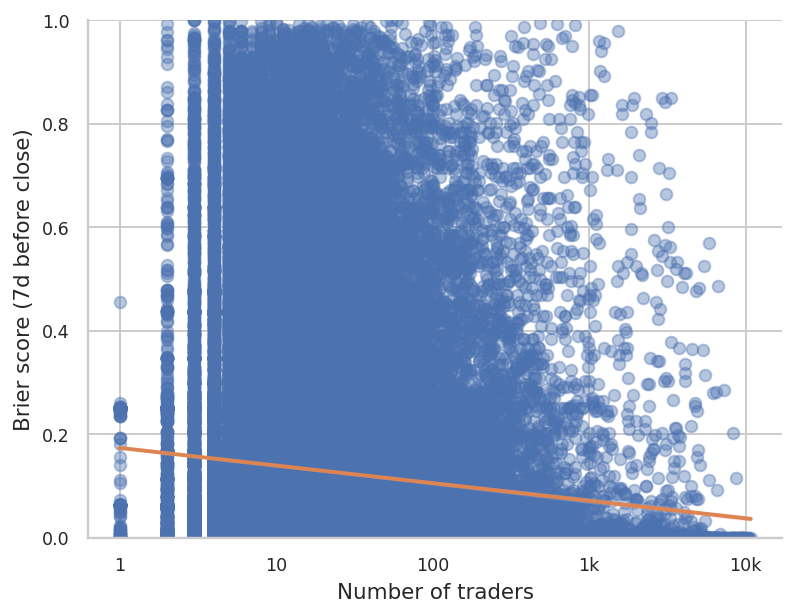

In [13]:
ax = sns.regplot(data=df, x='log_traders_count', y="score", scatter_kws={'alpha': 0.4}, line_kws={'lw': 2, 'color': 'C1'})
ax.set(xlabel='Number of traders', ylabel='Brier score (7d before close)', ylim=(0, 1), xticks=range(5), xticklabels=LOG_LABELS[:5])
plt.show()

Number of traders seems to show a similar trend to volume and again, the regression line is not very meaningful.
We will try binning the data into deciles again.

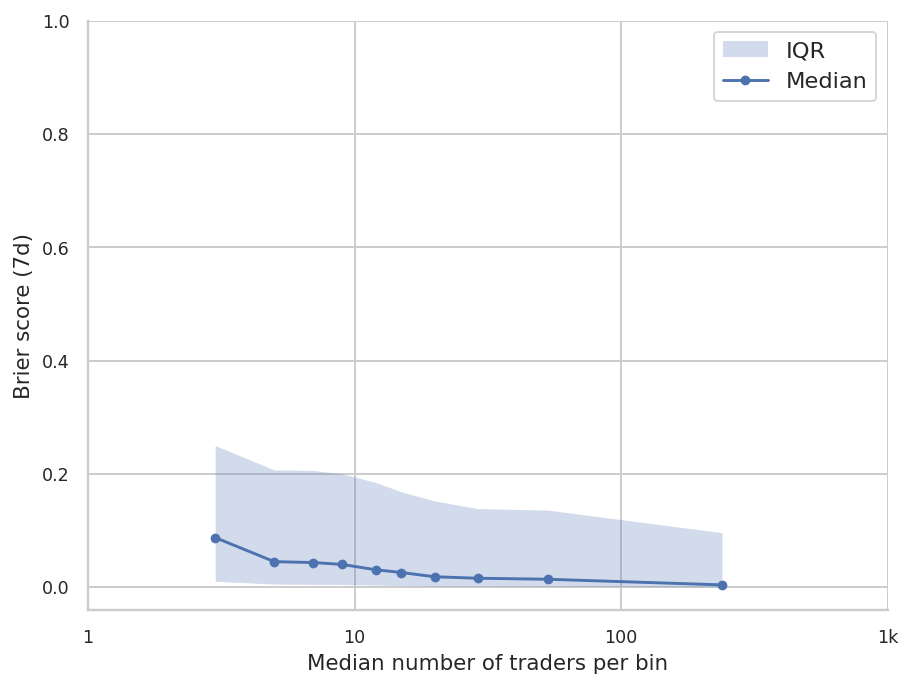

In [14]:
q = pd.qcut(df['traders_count'], 10, duplicates='drop')
h = (df.assign(bin=q)
     .groupby('bin', observed=False)
     .agg(traders_count_mid=('traders_count', 'median'),
          score_mid=('score', 'median'),
          score_q1=('score', lambda s: s.quantile(.25)),
          score_q3=('score', lambda s: s.quantile(.75)))
     .reindex())
fig, ax = plt.subplots(constrained_layout=True)
ax.fill_between(h['traders_count_mid'], h['score_q1'], h['score_q3'], alpha=0.25, linewidth=0, label='IQR')
ax.plot(h['traders_count_mid'], h['score_mid'], 'o-', lw=1.5, ms=4, label='Median')
ax.set(xscale='log', ylim=(-.04, 1), xlabel='Median number of traders per bin', ylabel='Brier score (7d)', xticks=10**np.arange(0, 4), xticklabels=LOG_LABELS[0:4])
ax.legend();
plt.show()

Looks similar to the volume accuracy relationship.

Let's repeat this for the higher volume markets, with the same criteria.

4886 rows with volume >= $5000, duration >= 30d and traders >= 20 remain.


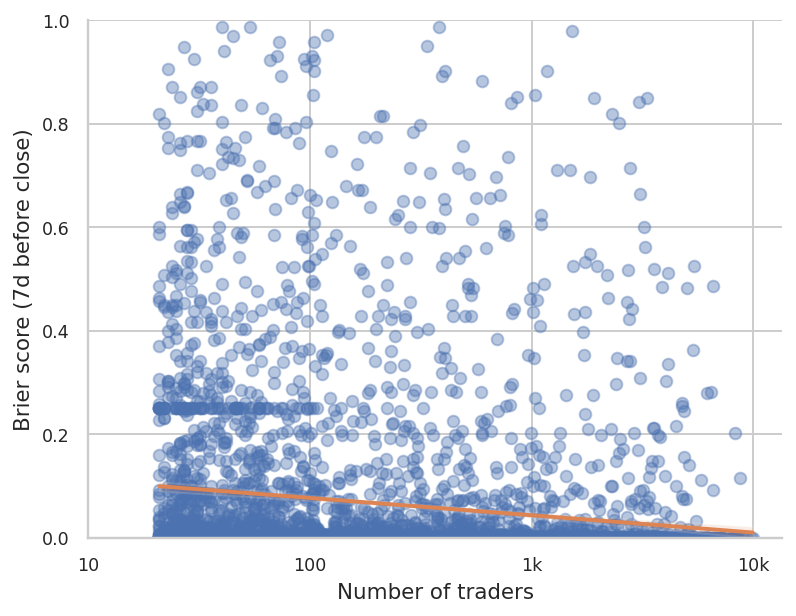

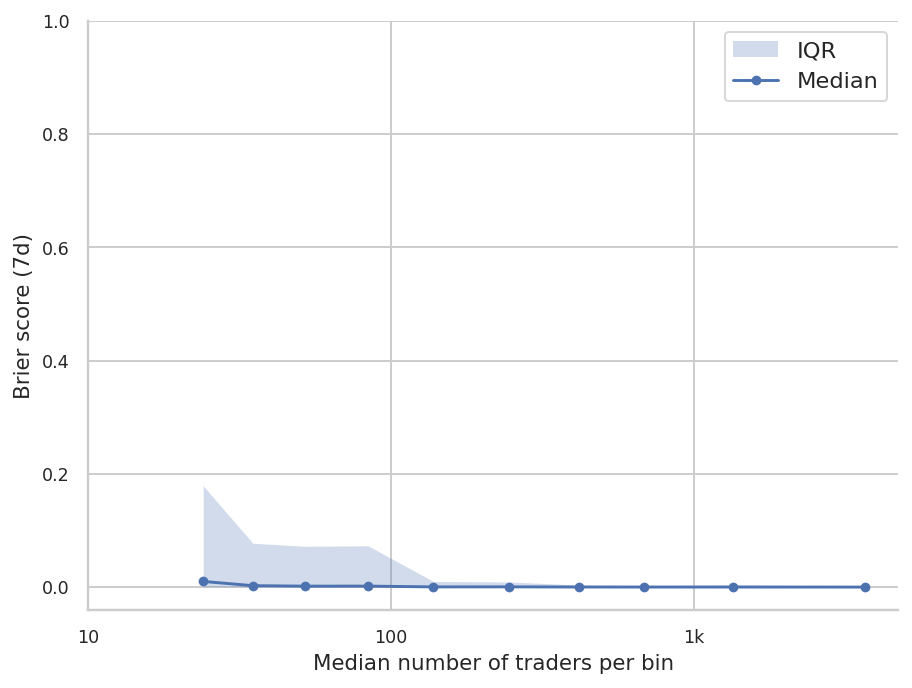

In [15]:
df_big = filter_high_volume(df)
print(
    f"{len(df_big)} rows with volume >= ${MIN_VOLUME}, duration >= {MIN_DURATION}d and traders >= {MIN_TRADERS} remain.")

ax = sns.regplot(data=df_big, x='log_traders_count', y="score", scatter_kws={'alpha': 0.4},
                 line_kws={'lw': 2, 'color': 'C1'})
ax.set(xlabel='Number of traders', ylabel='Brier score (7d before close)', ylim=(0, 1), xticks=range(1, 5), xticklabels=LOG_LABELS[1:5])
plt.show()

q = pd.qcut(df_big['traders_count'], 10, duplicates='drop')
h = (df_big.assign(bin=q)
     .groupby('bin', observed=False)
     .agg(traders_count_mid=('traders_count', 'median'),
          score_mid=('score', 'median'),
          score_q1=('score', lambda s: s.quantile(.25)),
          score_q3=('score', lambda s: s.quantile(.75)))
     .reindex())
fig, ax = plt.subplots(constrained_layout=True)
ax.fill_between(h['traders_count_mid'], h['score_q1'], h['score_q3'], alpha=0.25, linewidth=0, label='IQR')
ax.plot(h['traders_count_mid'], h['score_mid'], 'o-', lw=1.5, ms=4, label='Median')
ax.set(xscale='log', ylim=(-.04, 1), xlabel='Median number of traders per bin', ylabel='Brier score (7d)', xticks=10**np.arange(1, 4), xticklabels=LOG_LABELS[1:4])
ax.legend();
plt.show()

This, again, suggests the same trend, just a bit more pronounced.

In conclusion, the number of traders seems to also improve accuracy, but the returns are diminishing to an even greater extent than volume after just 50-100 traders.

## Calibration

Let's also look at calibration. We can do this by binning the predicted probabilities and looking at the actual outcomes in each bin.

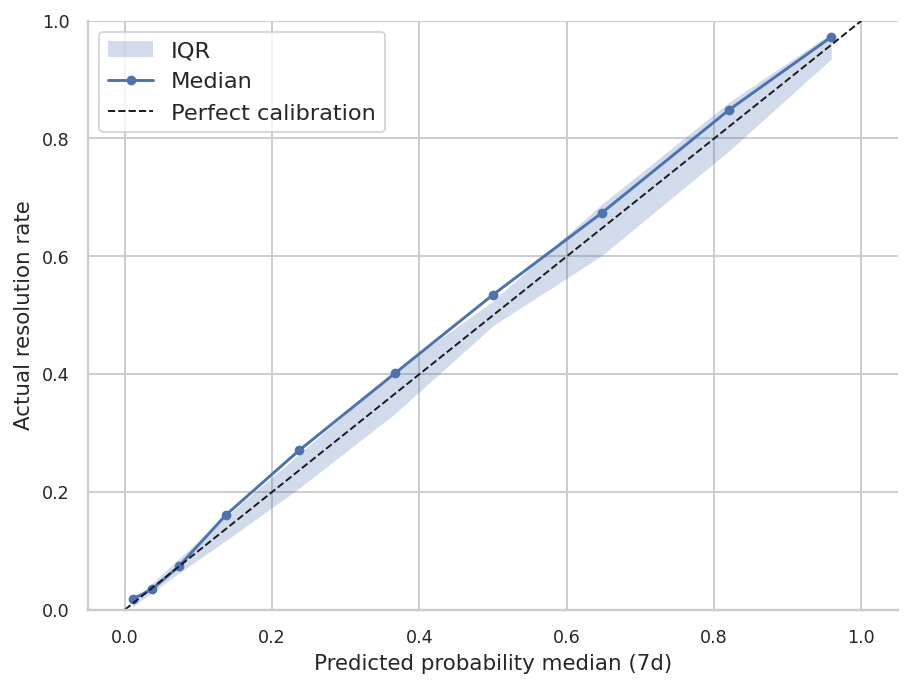

In [16]:
q = pd.qcut(df['probability'], 10, duplicates='drop')
h = (df.assign(bin=q).groupby(by='bin', observed=False)
     .agg(prob_mid=('probability', 'median'),
          prob_q1=('probability', lambda s: s.quantile(.25)),
          prob_q3=('probability', lambda s: s.quantile(.75)),
          actual_rate=('resolution', 'mean'),
          n=('resolution', 'count')))
fig, ax = plt.subplots(constrained_layout=True)
ax.fill_between(h['prob_mid'], h['prob_q1'], h['prob_q3'], alpha=0.25, linewidth=0, label='IQR')
ax.plot(h['prob_mid'], h['actual_rate'], 'o-', lw=1.5, ms=4, label='Median')
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Perfect calibration')
ax.set(ylim=(0, 1), xlabel='Predicted probability median (7d)', ylabel='Actual resolution rate')
ax.legend(); plt.show()

This is the markets binned by probabilities predicted at 7 days before close compared to actual resolution rate, with interquartile range shaded.

The straight diagonal line represents perfect calibration, compared to which the markets seem to be reasonably well-calibrated, with a small but consistent overconfidence bias.

## Category accuracy hypothesis

We'll test a simple hypothesis: markets are equally accurate in all categories. For the sake of simplicity, we'll just look at two categories. I picked politics and sports, as they have the most similar counts of markets.

We'll use the student t-test with a significance level of 0.05.

In [17]:
significance_level = 0.05
deduplicated = df['question_id'].isna() | ~df.duplicated('question_id') # only keep one market per question (and no question assigned markets)
politics = df.loc[deduplicated & (df['category'] == 'politics'), 'score']
sports = df.loc[deduplicated & (df['category'] == 'sports'), 'score']
test = stats.ttest_ind(politics, sports, equal_var=False)

print(f"Politics mean Brier score: {politics.mean():.4f} (n={len(politics)})")
print(f"Sports mean Brier score: {sports.mean():.4f} (n={len(sports)})")
print(f"T-test: statistic={test.statistic:.4f}, p-value={test.pvalue}")
print(f"The test p-value is {'less' if test.pvalue < significance_level else 'greater'} than the significance level of {significance_level}.")
if test.pvalue < significance_level:
    print("Reject null hypothesis: the two categories have different mean Brier scores.")
else:
    print("Fail to reject null hypothesis: the two categories have the same mean Brier scores.")

Politics mean Brier score: 0.1026 (n=23088)
Sports mean Brier score: 0.1469 (n=20047)
T-test: statistic=-23.2239, p-value=1.5152060598556244e-118
The test p-value is less than the significance level of 0.05.
Reject null hypothesis: the two categories have different mean Brier scores.


The null hypothesis that politics and sports markets have the same mean Brier score is rejected, indicating that the markets are not equally accurate in all categories.

It has to be noted that the independence assumption of the t-test does not necessarily hold, as even though we removed duplicate markets per question, there might still be correlations between questions. This should not change the overall conclusion though.

## Conclusion

We investigated various aspects of prediction market accuracy and calibration. Most of the results seem to indicate that prediction markets are reasonably accurate and well-calibrated, especially high-volume markets. There is also some evidence that markets are not equally accurate in all categories.